Work done by: Savelii Shaposhnyk (50%),  Yurii Huziienko (50%)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower
import re

In [2]:
station = pd.read_csv("./094/station.csv", sep='\t', engine="python")
patient = pd.read_csv("./094/patient.csv", sep='\t', engine="python")
observation = pd.read_csv("./094/observation.csv", sep='\t', engine="python")

## 1.1 A 

### Analýza štruktúr dát

### Initial rows of datasets


In [3]:
station.head()

,longitude,revision,station,QoS,latitude,location
0,123.33471,"12/25/2024, 00:00:00",Dipolog,acceptable,8.56697,Asia/Manila
1,-74.38987,2019-12-13,Scotch Plains,good,40.65538,America/New_York
2,-79.62098,2024-04-09,Chilibre,good,9.15093,America/Panama
3,101.02083,06 Nov 2020,Teluk Intan,excellent,4.02219,Asia/Kuala_Lumpur
4,-13.68778,"06/04/2016, 00:00:00",Camayenne,good,9.53500,Africa/Conakry


In [4]:
observation.head()

,SpO₂,HR,PI,RR,EtCO₂,FiO₂,PRV,BP,Skin Temperature,Motion/Activity index,...,CO,Blood Flow Index,PPG waveform features,Signal Quality Index,Respiratory effort,O₂ extraction ratio,SNR,oximetry,latitude,longitude
0,97.475846,81.591491,6.680550,14.547667,39.496499,52.714124,124.836732,104.217199,36.108288,10.754000,...,4.092998,44.905127,41.523414,49.049213,56.664361,0.249224,24.066451,1.0,41.27194,123.17306
1,97.912611,76.156279,4.803244,15.782442,40.602123,53.178448,105.447498,100.296240,37.117777,11.844240,...,4.029406,52.774329,48.513238,60.080573,41.287625,0.292653,38.017167,1.0,41.72059,-87.70172
2,98.121063,80.460804,9.015684,15.544800,38.909391,65.877665,107.324331,98.513655,35.707556,10.989627,...,4.073395,58.940415,53.573921,59.344096,55.326132,0.236367,22.600074,0.0,13.56667,-15.60000
3,96.939785,85.379659,11.913474,16.035582,38.179192,62.554479,116.852399,111.823930,35.633584,9.150543,...,4.202406,62.203451,54.141783,40.014563,64.637053,0.282531,34.726726,0.0,-4.24444,-42.29444
4,97.836588,83.231216,12.744535,17.060528,40.586055,72.593227,117.118128,98.025452,34.391785,12.160316,...,4.130695,62.177424,44.002227,49.768709,70.353246,0.267669,28.357028,0.0,52.53048,13.29371


In [5]:
patient.head()

,current_location,user_id,job,ssn,blood_group,company,name,address,mail,registration,username,residence,station_ID
0,"(Decimal('4.9861165'), Decimal('36.436181'))",1039,NaN,68497213564,O-,Silva S/A,Esther Peixoto,NaN,nda-rocha@uol.com.br,22 Sep 2023,machadomanuela,NaN,646
1,"(Decimal('-71.328162'), Decimal('112.765113'))",584,NaN,311-47-8562,AB+,中島ガス有限会社,森 篤司,兵庫県武蔵村山市竜泉24丁目13番14号 箭坪アーバン657,hideki18@hotmail.com,28 Apr 2024,mikakokato,NaN,612
2,"(Decimal('-27.747309'), Decimal('-18.204577'))",306,NaN,881-42-9055,B-,合同会社渡辺鉱業,西村 洋介,長崎県立川市横林18丁目22番4号 秋葉原ハイツ634,yukihasegawa@hotmail.com,23 Jan 2024,hanako61,NaN,611
3,"(Decimal('25.6202785'), Decimal('-123.630028'))",183,NaN,418-87-0731,O-,西村鉱業合同会社,前田 智也,熊本県調布市下吉羽31丁目15番1号,maayatanaka@yahoo.com,2019/01/06,fujitayosuke,NaN,411
4,"(Decimal('80.1195395'), Decimal('-40.214346'))",739,NaN,848-26-6511,A+,Ring,Amanda Ring,Budiggasse 54-68\n28723 Husum,daniloschmiedt@gmail.com,2022/03/12,bolandermatteo,NaN,666


### Statistics and information about datasets

In [6]:
patient.info()
patient.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102 entries, 0 to 2101
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   current_location  1997 non-null   object 
 1   user_id           2102 non-null   int64  
 2   job               631 non-null    object 
 3   ssn               2102 non-null   object 
 4   blood_group       2102 non-null   object 
 5   company           2102 non-null   object 
 6   name              2102 non-null   object 
 7   address           1787 non-null   object 
 8   mail              2102 non-null   object 
 9   registration      2102 non-null   object 
 10  username          2102 non-null   object 
 11  residence         0 non-null      float64
 12  station_ID        2102 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 213.6+ KB


,current_location,user_id,job,ssn,blood_group,company,name,address,mail,registration,username,residence,station_ID
count,1997,2102.000000,631,2102,2102,2102,2102,1787,2102,2102,2102,0.0,2102.000000
unique,1997,NaN,402,2102,8,1905,2059,1787,2097,1898,2086,NaN,NaN
top,"(Decimal('-33.053838'), Decimal('176.740753'))",NaN,Ausbaufacharbeiter,CNTMCL19T65C268E,O+,Campos,前田 智也,"Viale Dante, 26\n39053, Contrada Val D'Ega (BZ)",yoshidataichi@yahoo.com,2019/02/18,naokitanaka,NaN,NaN
freq,1,NaN,9,1,291,6,3,1,2,3,3,NaN,NaN
mean,NaN,1069.634158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,404.445766
std,NaN,604.326342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232.547149
min,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,539.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.250000
50%,NaN,1087.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,405.000000
75%,NaN,1593.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,611.000000


In [7]:
station.info()
station.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  798 non-null    float64
 1   revision   798 non-null    object 
 2   station    798 non-null    object 
 3   QoS        798 non-null    object 
 4   latitude   798 non-null    float64
 5   location   798 non-null    object 
dtypes: float64(2), object(4)
memory usage: 37.5+ KB


,longitude,revision,station,QoS,latitude,location
count,798.000000,798,798,798,798.000000,798
unique,NaN,775,544,4,NaN,142
top,NaN,30 Nov 2017,Budva,good,NaN,Asia/Kolkata
freq,NaN,3,5,387,NaN,61
mean,7.533613,NaN,NaN,NaN,30.049260,NaN
std,74.086131,NaN,NaN,NaN,22.707970,NaN
min,-156.474320,NaN,NaN,NaN,-54.800000,NaN
25%,-71.089770,NaN,NaN,NaN,17.649250,NaN
50%,8.872390,NaN,NaN,NaN,36.634030,NaN
75%,68.949943,NaN,NaN,NaN,46.670465,NaN


In [8]:
observation.info()
observation.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12081 entries, 0 to 12080
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SpO₂                   12081 non-null  float64
 1   HR                     12081 non-null  float64
 2   PI                     12081 non-null  float64
 3   RR                     12081 non-null  float64
 4   EtCO₂                  12081 non-null  float64
 5   FiO₂                   12081 non-null  float64
 6   PRV                    12081 non-null  float64
 7   BP                     12081 non-null  float64
 8   Skin Temperature       12081 non-null  float64
 9   Motion/Activity index  12081 non-null  float64
 10  PVI                    12081 non-null  float64
 11  Hb level               12081 non-null  float64
 12  SV                     12081 non-null  float64
 13  CO                     12081 non-null  float64
 14  Blood Flow Index       12081 non-null  float64
 15  PP

,SpO₂,HR,PI,RR,EtCO₂,FiO₂,PRV,BP,Skin Temperature,Motion/Activity index,...,CO,Blood Flow Index,PPG waveform features,Signal Quality Index,Respiratory effort,O₂ extraction ratio,SNR,oximetry,latitude,longitude
count,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,...,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000
mean,97.543356,79.413685,8.712491,16.136178,39.656629,59.468329,117.625701,104.439286,35.991422,10.946974,...,4.099589,45.611526,47.452354,46.824160,49.850686,0.249556,29.965134,0.593742,30.012531,7.562794
std,0.604163,4.958332,3.500894,1.031022,1.429944,10.774090,21.832746,4.083631,0.841526,1.444792,...,0.134870,12.299427,11.977231,12.180977,13.997603,0.028916,5.757217,0.491154,22.724710,74.036077
min,95.000000,60.000000,0.200000,12.000000,35.000000,21.000000,20.000000,90.000000,33.000000,5.184462,...,4.000000,0.000000,0.000000,0.000000,0.000000,0.200000,20.000000,0.000000,-54.800000,-156.474320
25%,97.143688,76.070752,5.904762,15.451710,38.606414,52.247203,103.013231,101.692402,35.348685,10.004359,...,4.029280,37.421792,39.416531,38.596050,40.471794,0.224572,24.961313,0.000000,17.549070,-71.089770
50%,97.548163,79.408554,8.129926,16.136063,39.625901,59.501149,117.650792,104.383271,36.133526,10.920158,...,4.059159,45.547703,47.312822,46.905686,49.889828,0.249176,30.022978,1.000000,36.619540,8.863740
75%,97.952928,82.767663,11.658857,16.828594,40.710631,66.666371,132.126611,107.208491,36.644071,11.860327,...,4.118594,53.882516,55.547389,54.945963,59.455099,0.274651,34.911579,1.000000,46.675350,69.013540
max,100.000000,100.000000,20.000000,20.000000,45.000000,100.000000,200.000000,120.000000,38.000000,18.102959,...,8.000000,100.000000,100.000000,100.000000,100.000000,0.300000,40.000000,1.000000,68.798330,178.004170


### Data type, shape and missing values

In [9]:
def datatypes_counts(df): 
    return df.dtypes.astype(str).value_counts().to_dict()

In [10]:
patient_summary = {
    "Number_of_lines": patient.shape[0],
    "Number_of_columns": patient.shape[1],
    "Data_types": datatypes_counts(patient),
    "Missing_total": int(patient.isna().sum().sum())
}
patient_summary

{'Number_of_lines': 2102,
 'Number_of_columns': 13,
 'Data_types': {'object': 10, 'int64': 2, 'float64': 1},
 'Missing_total': 3993}

In [11]:
station_summary = {
    "Number_of_lines": station.shape[0],
    "Number_of_columns": station.shape[1],
    "Data_types": datatypes_counts(station),
    "Missing_total": int(station.isna().sum().sum())
}
station_summary

{'Number_of_lines': 798,
 'Number_of_columns': 6,
 'Data_types': {'object': 4, 'float64': 2},
 'Missing_total': 0}

In [12]:
observation_summary = {
    "Number_of_lines": observation.shape[0],
    "Number_of_columns": observation.shape[1],
    "Data_types": datatypes_counts(observation),
    "Missing_total": int(observation.isna().sum().sum())
}
observation_summary

{'Number_of_lines': 12081,
 'Number_of_columns': 23,
 'Data_types': {'float64': 23},
 'Missing_total': 0}

### Data analysis – records and attributes
| File                |   Rows | Columns | Data types                    | Missing values |
| :------------------ | -----: | ------: | :---------------------------- | -------------: |
| **patient.csv**     |  2 102 |      13 | 10×object, 2×int64, 1×float64 |          3 993 |
| **station.csv**     |    798 |       6 | 4×object, 2×float64           |              0 |
| **observation.csv** | 12 081 |      23 | 23×float64                    |              0 |



### Analysis of missing values
Based on all the omitted values listed above, we will check what exactly has been omitted.

In [13]:
missing_percento = (patient.isna().sum() / len(patient) * 100).sort_values(ascending=False).round(2)
missing_percento.head(10)

residence           100.00
job                  69.98
address              14.99
current_location      5.00
user_id               0.00
blood_group           0.00
ssn                   0.00
name                  0.00
company               0.00
mail                  0.00
dtype: float64

 From the calculation of the percentage of missing values, we can see that some attributes contain a significant number of empty records, so we will make a complete conclusion about our data.

Dataset: patient.csv
- Number of records: 2102
- Number of attributes: 13
- Data types: object, int64, float64
- Missing values total = 3993  
  - Most missing: residence (100%), job (70%), address (15%), current_location (5%).  
- Description: contains demographic information about patients and a link to the station (station_ID).  
Cannot be directly linked to the station file.

Dataset: station.csv
- Number of records: 798
- Number of attributes: 6
- Data types: object, float64  
- Missing values: 0 
- Description: contains information about measuring stations — station, latitude, longitude etc.  
- Observation: revision values use different date formats, so normalization is required in further steps.

Dataset: observation.csv
- Number of records: 12,081
- Number of attributes: 23  
- Data types: float64 
- Missing values: 0  
- Target variable: oxygen saturation (0/1).
- Attributes: SpO₂, HR, Skin Temperature, BP, CO, FiO₂, etc.

## 1.1 B

### Chosen attributes

In [14]:
skin_temp = observation["Skin Temperature"]
spo = observation["SpO₂"]
hr =  observation["HR"]
pi = observation["PI"]
rr = observation["RR"]  
prv = observation["PRV"]
bp = observation["BP"]
pvi = observation["PVI"]
sv = observation["SV"]
co = observation["CO"]

### General statistics and information about attributes

In [15]:
cols = ["Skin Temperature", "SpO₂", "HR", "PI", "RR", "PRV", "BP", "PVI", "SV", "CO"]
observation[cols].describe()

,Skin Temperature,SpO₂,HR,PI,RR,PRV,BP,PVI,SV,CO
count,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000
mean,35.991422,97.543356,79.413685,8.712491,16.136178,117.625701,104.439286,15.327157,80.861939,4.099589
std,0.841526,0.604163,4.958332,3.500894,1.031022,21.832746,4.083631,1.582654,4.996021,0.134870
min,33.000000,95.000000,60.000000,0.200000,12.000000,20.000000,90.000000,10.000000,60.000000,4.000000
25%,35.348685,97.143688,76.070752,5.904762,15.451710,103.013231,101.692402,14.141627,77.522258,4.029280
50%,36.133526,97.548163,79.408554,8.129926,16.136063,117.650792,104.383271,15.373838,80.813695,4.059159
75%,36.644071,97.952928,82.767663,11.658857,16.828594,132.126611,107.208491,16.623524,84.290286,4.118594
max,38.000000,100.000000,100.000000,20.000000,20.000000,200.000000,120.000000,20.000000,100.000000,8.000000


### Visualisation of attributes

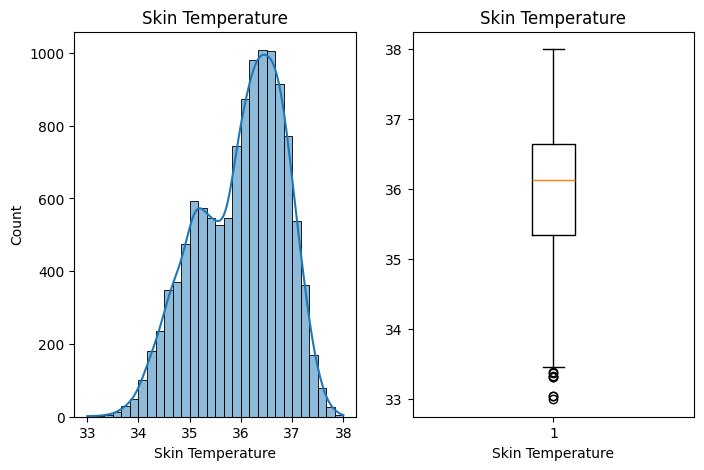

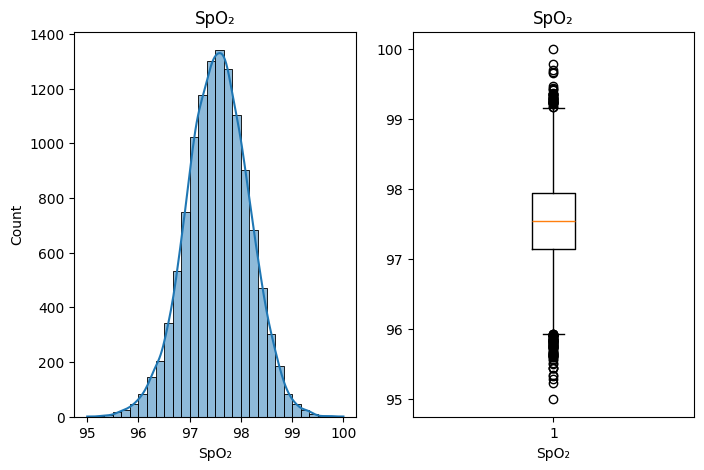

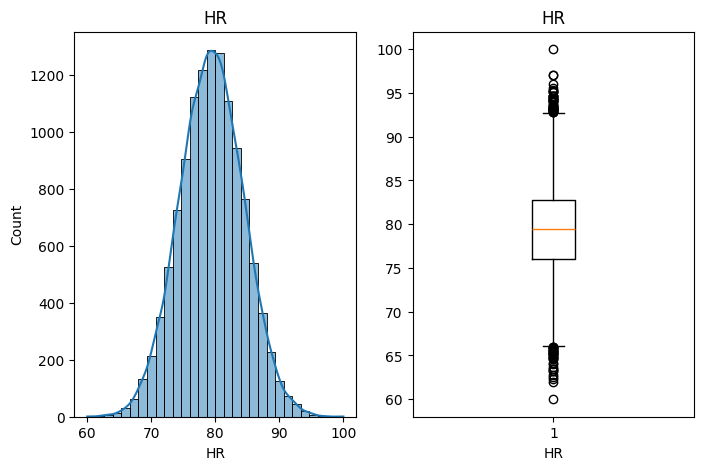

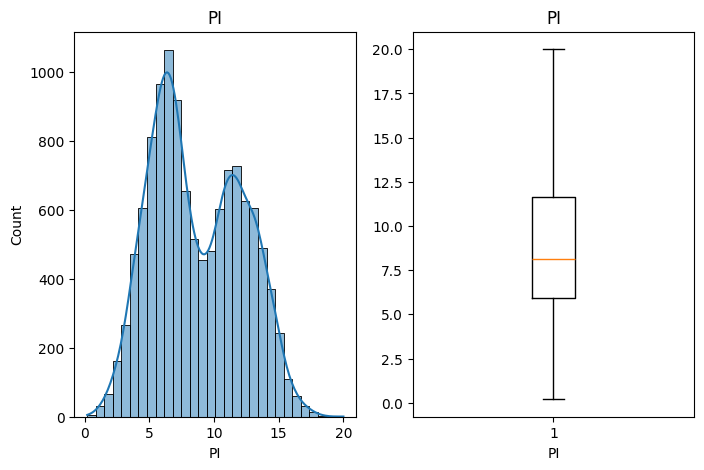

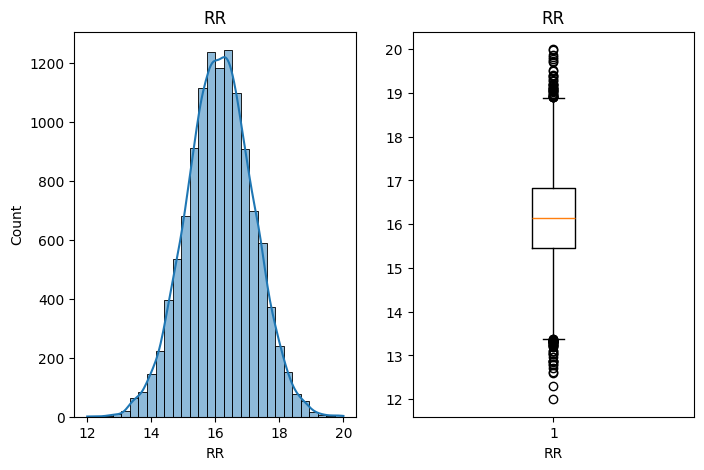

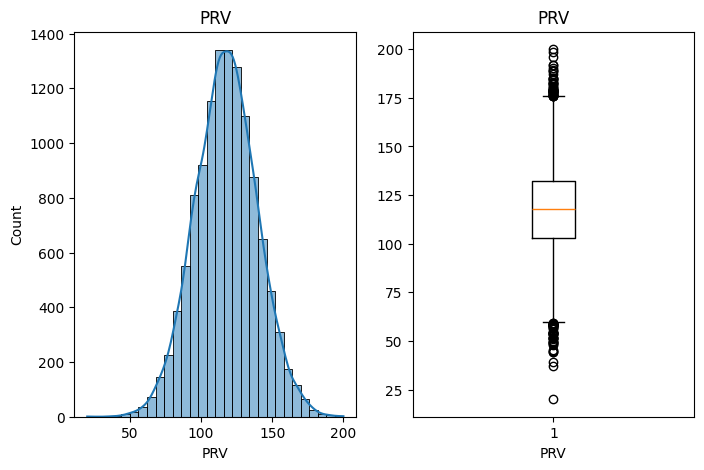

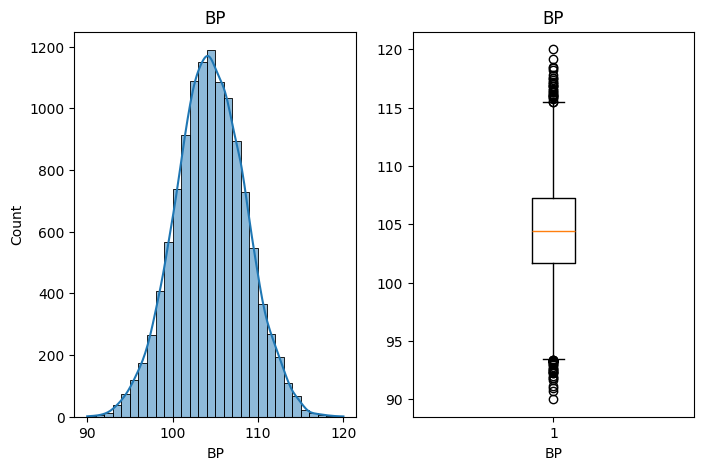

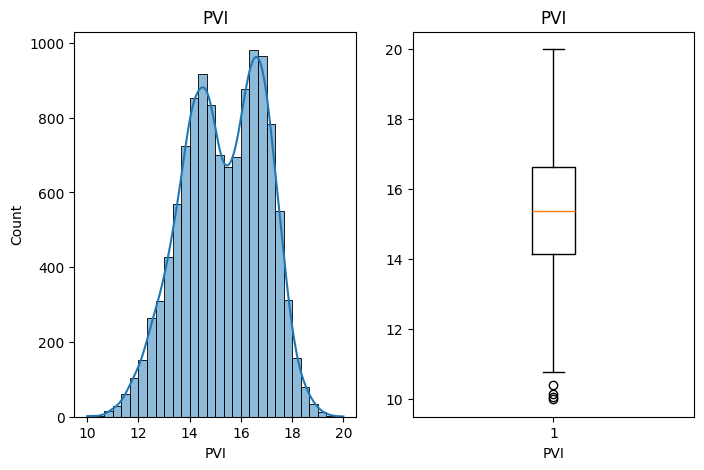

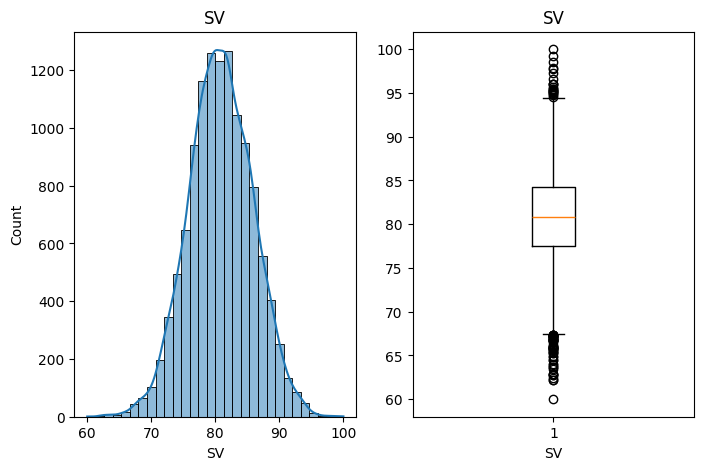

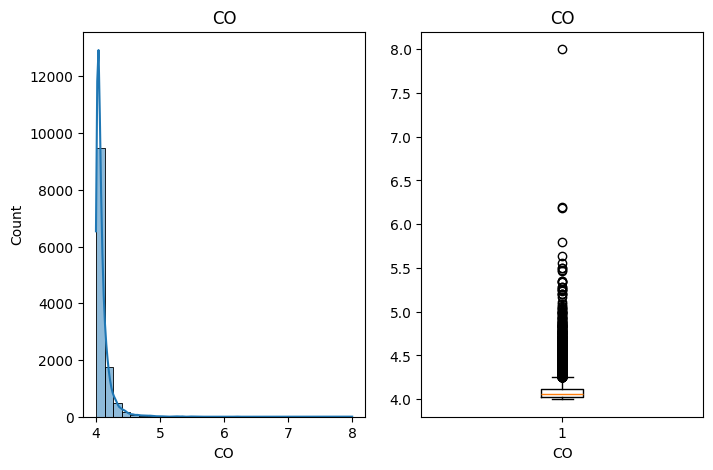

In [16]:
for col in cols:
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(observation[col], bins=30, kde=True)
    plt.title(f'{col}')
    plt.xlabel(f'{col}')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(observation[col])
    plt.title(f'{col}')
    plt.xlabel(f'{col}')
    plt.show()

We can see that almost every chosen attribute have normal distribution, and also they have outliers as well

## 1.1 C

### Identify relationships and dependencies between pairs of attributes

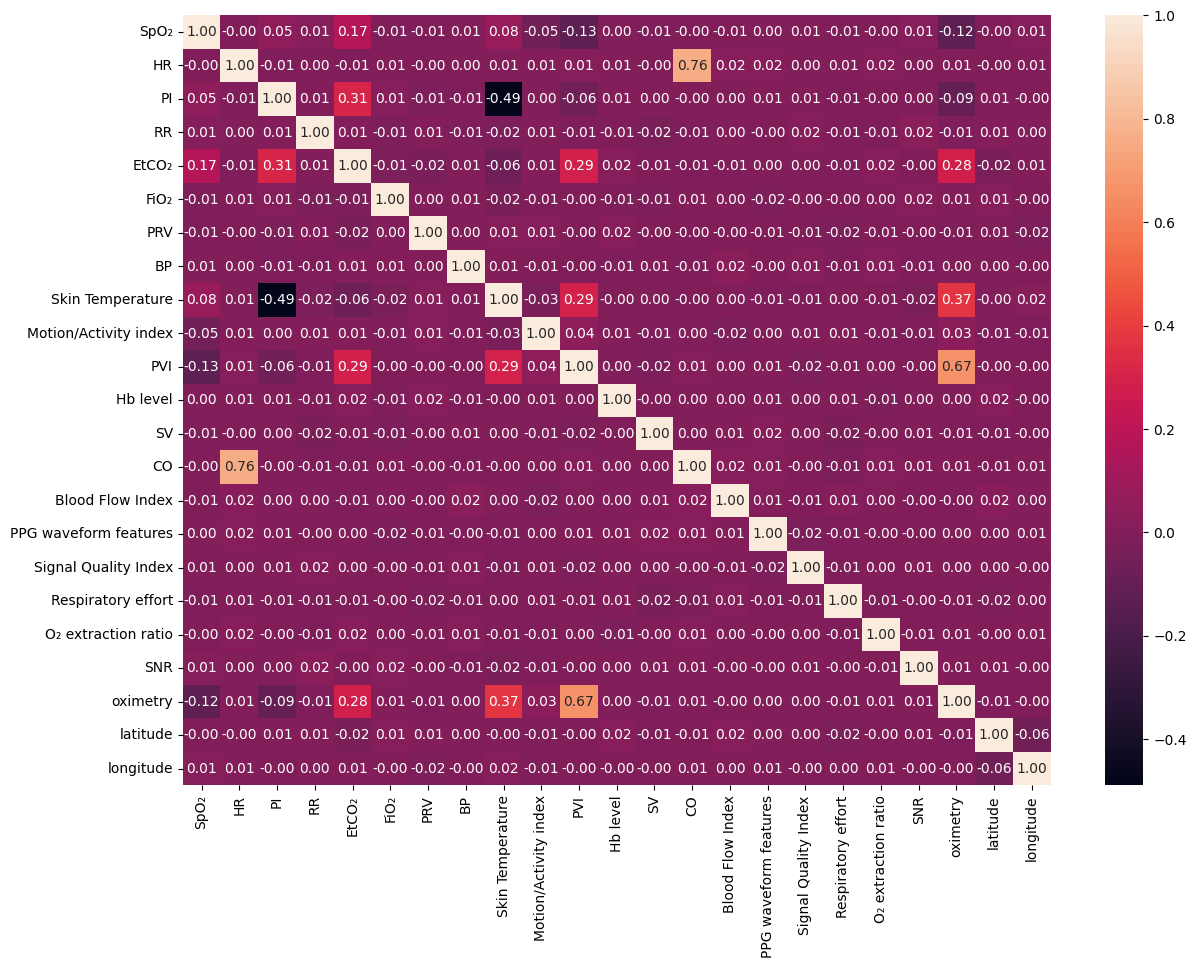

In [17]:
corr = observation.corr(numeric_only=False)

plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

In [18]:
corr_prs = corr.unstack().sort_values(key=lambda x: x.abs(), ascending=False)
corr_prs = corr_prs[(corr_prs < 0.999) & (corr_prs > -0.999)]
corr_prs.drop_duplicates(inplace=True)
print("Top correlations:\n")
print(corr_prs.head(6))

Top correlations:

CO                HR                  0.758996
PVI               oximetry            0.666416
Skin Temperature  PI                 -0.489184
                  oximetry            0.368207
EtCO₂             PI                  0.311975
PVI               Skin Temperature    0.292201
dtype: float64


### Interpretation of paired data analysis results

Several significant relationships can be identified:

**CO and HR (r = 0.76)** – dependence between heart rate and cardiac output.

**Oximetry and PVI (r = 0.67)** – oxygen saturation is closely related to perfusion variability.

**Skin Temperature and PI (r = –0.49)** – inverse relationship between skin temperature and perfusion index: as the skin temperature decreases, the perfusion index tends to increase

**Skin Temperature and Oximetry (r = 0.37)** – correlation between peripheral temperature and saturation.

**EtCO₂ and PI (r = 0.31)** – correlation between exhaled CO₂ and perfusion index.

**PVI and Skin Temperature (r = 0.29)** – relationship between perfusion variability and skin temperature.  

Most other attributes do not show statistically significant linear relationships.

These findings point to physiological relationships between selected variables
and help determine which attributes may be relevant in future modeling
and prediction of the target variable `oximetry`.

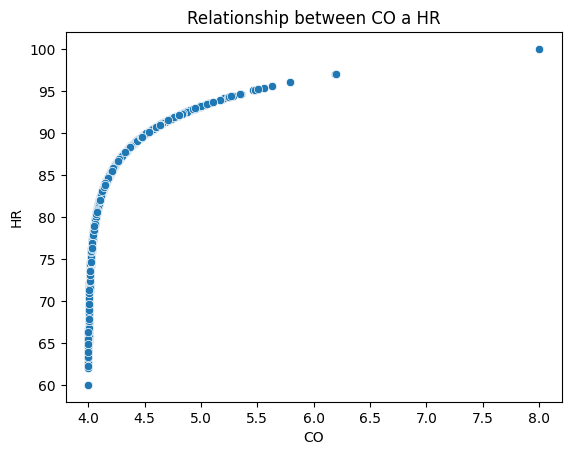

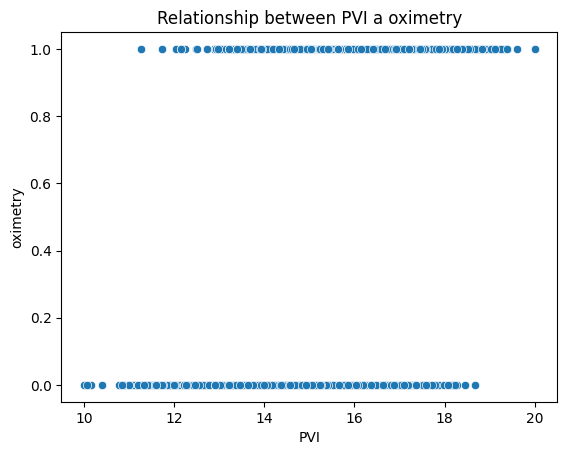

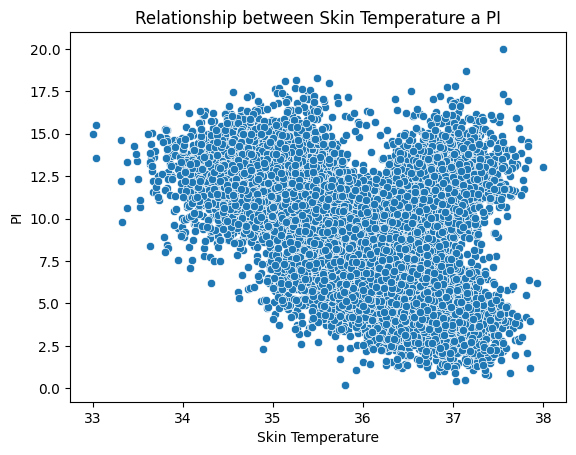

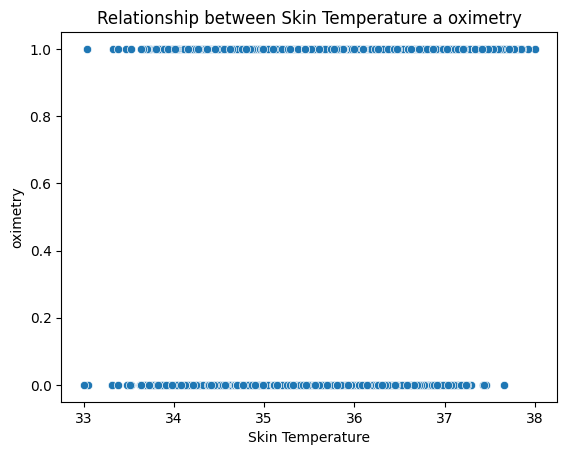

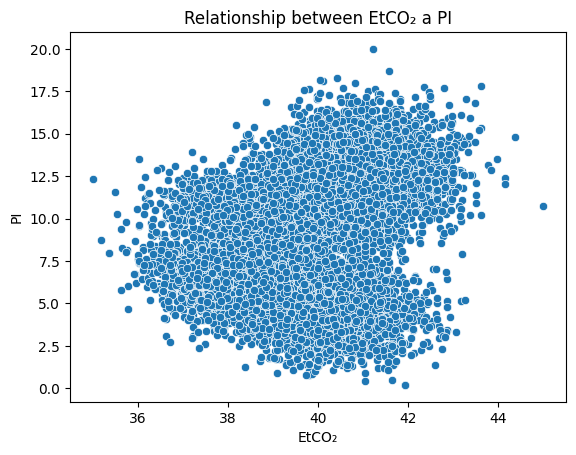

In [19]:
pairs_to_plot = [pair for pair, value in corr_prs.head(5).items()]

for x, y in pairs_to_plot:
    sns.scatterplot(data=observation, x=x, y=y)
    plt.title(f"Relationship between {x} a {y}")
    plt.show()

#### CO - HR
The graph shows a strong positive correlation between cardiac output (CO) and heart rate (HR).
With higher cardiac output, heart rate also increases, which is expected from a physiological point of view.
The points form a curved shape, indicating that the relationship is not completely linear, but strongly positive.

#### EtCO a PI
The values are more evenly distributed on this graph. There is a slight positive correlation between
the concentration of carbon dioxide in exhaled air (EtCO₂) and the perfusion index (PI).
The relationship is not strong, but it confirms that changes in breathing can partially affect peripheral perfusion.

## 1.1 D

### Correlation between the predicted variable

In [20]:
corr = observation.corr(numeric_only=False)
corr['oximetry'].sort_values()

SpO₂                    -0.121493
PI                      -0.093795
SV                      -0.008412
PRV                     -0.008249
RR                      -0.007365
latitude                -0.007289
Respiratory effort      -0.005237
Blood Flow Index        -0.000773
longitude               -0.000683
BP                       0.000745
Signal Quality Index     0.002155
PPG waveform features    0.002664
Hb level                 0.004894
O₂ extraction ratio      0.005265
FiO₂                     0.006180
HR                       0.008207
CO                       0.009428
SNR                      0.010472
Motion/Activity index    0.028967
EtCO₂                    0.281626
Skin Temperature         0.368207
PVI                      0.666416
oximetry                 1.000000
Name: oximetry, dtype: float64

Our predicted variable have a very strong correlation with **PVI**, **Skin Temperature**, **EtCO₂** and not very strong negative correlation with **SpO₂**

### Visualisation of correlations

In [21]:
attributes = ['PVI', 'Skin Temperature', 'EtCO₂', 'SpO₂']

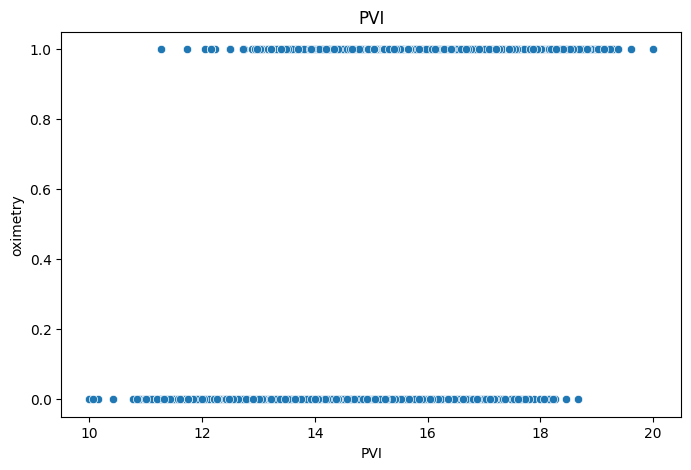

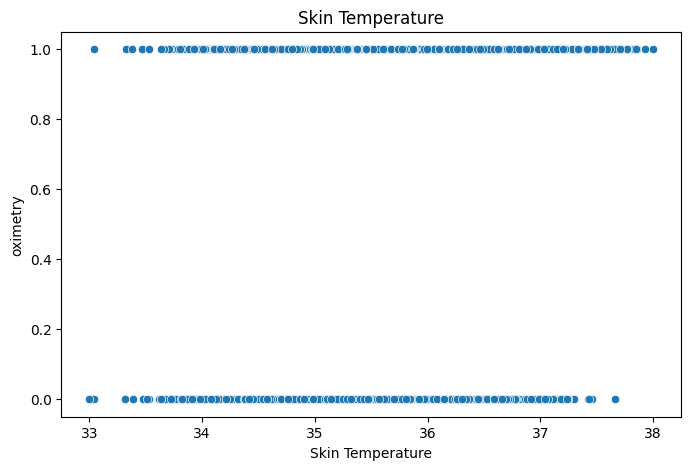

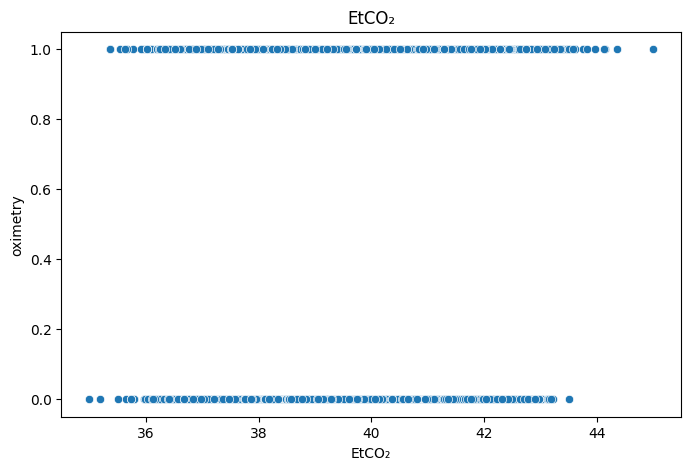

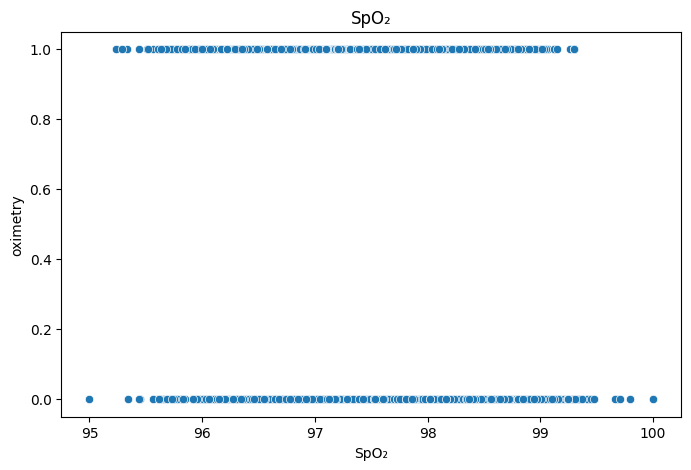

In [22]:
for attribute in attributes:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=observation, x=f'{attribute}', y='oximetry')
    plt.title(f'{attribute}')
    plt.xlabel(f'{attribute}')
    plt.show()

## (E-1b)

After analysis, we can seen that there is a strong correlation between the **CO** and **HR** variables (r = 0.76) also variables **PI** and **EtCO₂** (r = 0.31) and also **Skin Temperature** and **PVI** (r = 0.299) and also a negative correlation between **Skin Temperature and PI (r = –0.49)**

Our target variable, oximetry, is most strongly dependent on **PVI** (r = 0.66) **Skin Temperature** (r = 0.368), and **EtCO₂** (r = 0.281),
and also has a negative correlation with **SpO₂** (r = −0.121)

We don't need to combine other datasets, all required the information is already in the observation dataset

## (A-2b)

### Check data types

In [23]:
observation.dtypes

SpO₂                     float64
HR                       float64
PI                       float64
RR                       float64
EtCO₂                    float64
FiO₂                     float64
PRV                      float64
BP                       float64
Skin Temperature         float64
Motion/Activity index    float64
PVI                      float64
Hb level                 float64
SV                       float64
CO                       float64
Blood Flow Index         float64
PPG waveform features    float64
Signal Quality Index     float64
Respiratory effort       float64
O₂ extraction ratio      float64
SNR                      float64
oximetry                 float64
latitude                 float64
longitude                float64
dtype: object

In [24]:
station.dtypes

longitude    float64
revision      object
station       object
QoS           object
latitude     float64
location      object
dtype: object

In [25]:
patient.dtypes

current_location     object
user_id               int64
job                  object
ssn                  object
blood_group          object
company              object
name                 object
address              object
mail                 object
registration         object
username             object
residence           float64
station_ID            int64
dtype: object

### Format data types

In [26]:
station['revision'] = pd.to_datetime(station['revision'], format="mixed")
station['station'] = station['station'].astype('string')
station['QoS'] = station['QoS'].astype('category')
station['location'] = station['location'].astype('string')

In [27]:
patient['job'] = patient['job'].astype('string')
patient['ssn'] = patient['ssn'].astype('string')
patient['blood_group'] = patient['blood_group'].astype('category')
patient['company'] = patient['company'].astype('string')
patient['name'] = patient['name'].astype('string')
patient['username'] = patient['username'].astype('string')
patient['residence'] = patient['residence'].astype('string')
patient['registration'] = patient['registration'].astype('string')
patient['address'] = patient['address'].astype('string')
patient['mail'] = patient['mail'].astype('string')
patient[['longitude', 'latitude']] = (
    patient['current_location']
    .astype(str)
    .str.extract(r"Decimal\('([\d\.\-]+)'\), Decimal\('([\d\.\-]+)'\)")
    .astype(float)
)
patient.drop(columns=['current_location'], inplace=True)

### Check nulls

In [28]:
observation.isnull().sum()

SpO₂                     0
HR                       0
PI                       0
RR                       0
EtCO₂                    0
FiO₂                     0
PRV                      0
BP                       0
Skin Temperature         0
Motion/Activity index    0
PVI                      0
Hb level                 0
SV                       0
CO                       0
Blood Flow Index         0
PPG waveform features    0
Signal Quality Index     0
Respiratory effort       0
O₂ extraction ratio      0
SNR                      0
oximetry                 0
latitude                 0
longitude                0
dtype: int64

In [29]:
station.isnull().sum()

longitude    0
revision     0
station      0
QoS          0
latitude     0
location     0
dtype: int64

In [30]:
patient.isnull().sum()

user_id            0
job             1471
ssn                0
blood_group        0
company            0
name               0
address          315
mail               0
registration       0
username           0
residence       2102
station_ID         0
longitude        105
latitude         105
dtype: int64

We have a lot of nulls in **patient** dataset, so we need to put some default values

In [31]:
patient['residence'] = patient['residence'].fillna('Unknown')
patient['job'] = patient['job'].fillna('Unknown')
patient['address'] = patient['address'].fillna('Unknown')
patient['longitude'] = patient['longitude'].fillna(0)
patient['latitude'] = patient['latitude'].fillna(0)

### Check duplicates

In [32]:
observation.duplicated().sum()

np.int64(1)

In [33]:
station.duplicated().sum()

np.int64(0)

In [34]:
patient.duplicated().sum()

np.int64(0)

We have one duplicate in **observation** dataset, we need to clean it

### Clean duplicates

In [35]:
observation = observation.drop_duplicates()

## 1.2 B

In [36]:
ranges = pd.read_csv("./094/sensor_variable_range.csv", sep="\t")
print(ranges.head())

  Variable         Unit                     Description        Value Range
0     SpO₂            %    Peripheral oxygen saturation            95–100%
1       HR          bpm  Heart rate from pulse oximeter         60–100 bpm
2       PI            %                 Perfusion index            0.2–20%
3       RR  breaths/min                Respiratory rate  12–20 breaths/min
4    EtCO₂         mmHg        End-tidal carbon dioxide         35–45 mmHg


In [37]:
num_pat = re.compile(r"[-+]?\d+(?:[.,]\d+)?")
def parse_range(s):
    nums = num_pat.findall(str(s))
    if len(nums) >= 2:
        a = float(nums[0].replace(",", "."))
        b = float(nums[1].replace(",", "."))
        lo, hi = (a, b) if a <= b else (b, a)
        return lo, hi
    return None, None

ranges[["Min", "Max"]] = ranges["Value Range"].apply(lambda r: pd.Series(parse_range(r)))
ranges = ranges.dropna(subset=["Min", "Max"])
ranges.loc[ranges["Variable"] == "BP", ["Min", "Max"]] = [90.0, 120.0]
print(ranges[["Variable", "Min", "Max"]].reset_index(drop=True))

                Variable   Min    Max
0                   SpO₂  95.0  100.0
1                     HR  60.0  100.0
2                     PI   0.2   20.0
3                     RR  12.0   20.0
4                  EtCO₂  35.0   45.0
5                   FiO₂  21.0  100.0
6                    PRV  20.0  200.0
7                     BP  90.0  120.0
8       Skin Temperature  33.0   38.0
9                    PVI  10.0   20.0
10              Hb level  12.0   18.0
11                    SV  60.0  100.0
12                    CO   4.0    8.0
13  Signal Quality Index   0.0  100.0
14   O₂ extraction ratio   0.2    0.3
15                   SNR  20.0   40.0


In [38]:
records = []

for var, low, high in zip(ranges["Variable"], ranges["Min"], ranges["Max"]):
    if var in observation.columns:
        vals = pd.to_numeric(observation[var], errors="coerce")
        mask = (vals < low) | (vals > high)
        records.append({
            "Attribute": var,
            "Number of abnormal values": int(mask.sum()),
            "Allowed range": f"{low} – {high}",
            "Examples idx": mask[mask].index.tolist()
        })
        
anomalies_df = pd.DataFrame(records).sort_values("Number of abnormal values", ascending=False).reset_index(drop=True)
anomalies_df

,Attribute,Number of abnormal values,Allowed range,Examples idx
0,SpO₂,0,95.0 – 100.0,[]
1,HR,0,60.0 – 100.0,[]
2,PI,0,0.2 – 20.0,[]
3,RR,0,12.0 – 20.0,[]
4,EtCO₂,0,35.0 – 45.0,[]
5,FiO₂,0,21.0 – 100.0,[]
6,PRV,0,20.0 – 200.0,[]
7,BP,0,90.0 – 120.0,[]
8,Skin Temperature,0,33.0 – 38.0,[]
9,PVI,0,10.0 – 20.0,[]


### Kontrola správnosti v dátach

Dáta z *observation.csv* boli porovnané s referenčnými rozsahmi fyziologických parametrov zo *sensor_variable_range.csv*.  
V žiadnom z atribútov neboli zistené abnormálne hodnoty mimo definovaných intervalov, čo naznačuje, že dataset neobsahuje chybné alebo extrémne merania.  

Pre istotu bola ďalej vykonaná kontrola nelogických kombinácií hodnôt
(vzťahov medzi atribútmi), ktoré by mohli naznačovať chyby senzora alebo anotácie.

In [39]:
logic_errors = []

# Pressure = 0 when pulse is present
mask = (observation["BP"] == 0) & (observation["HR"] > 0)
logic_errors.append(("BP = 0 a HR > 0", mask.sum()))

# Does the measured cardiac output (CO) match the calculated value based on heart rate (HR) and stroke volume (SV)
co_est = observation["HR"] * observation["SV"] / 1000.0
mask = (observation["CO"] - co_est).abs() > 0.5 * co_est.fillna(0).abs()
logic_errors.append(("|CO - HR*SV/1000| > 50%", mask.sum()))

# if the signal quality is >= 80%, but the signal to noise ratio is < 20 dB (strong noise), then the data is contradictory.
mask = (observation["Signal Quality Index"] >= 80) & (observation["SNR"] < 20)
logic_errors.append(("Signal Quality Index >= 80 a SNR < 20", mask.sum()))

# It is impossible to accurately measure ideal saturation with a poor signal.
mask = (observation["Signal Quality Index"] <= 10) & (observation["SpO₂"] >= 99)
logic_errors.append(("Signal Quality Index <= 10 a SpO₂ >= 99", mask.sum()))

# When breathing normal air, saturation should not be this low.
mask = (observation["FiO₂"] <= 22) & (observation["SpO₂"] < 85)
logic_errors.append(("FiO₂ ≈ 21% a SpO₂ < 85%", mask.sum()))

# Do such coordinates exist on Earth?
mask = (
    (observation["latitude"] < -90) |
    (observation["latitude"] > 90) |
    (observation["longitude"] < -180) |
    (observation["longitude"] > 180)
)
logic_errors.append(("Latitude/Longitude out of range", mask.sum()))

# Unrealistic combination — a person breathes often, but exhales almost no CO₂.
mask = (observation["RR"] > 40) & (observation["EtCO₂"] < 20)
logic_errors.append(("RR > 40 a EtCO₂ < 20", mask.sum()))

logic_df = pd.DataFrame(logic_errors, columns=["-", "Number of violations"])
logic_df

,-,Number of violations
0,BP = 0 a HR > 0,0
1,|CO - HR*SV/1000| > 50%,0
2,Signal Quality Index >= 80 a SNR < 20,0
3,Signal Quality Index <= 10 a SpO₂ >= 99,0
4,FiO₂ ≈ 21% a SpO₂ < 85%,0
5,Latitude/Longitude out of range,0
6,RR > 40 a EtCO₂ < 20,0


### Data accuracy check

Based on the reference ranges from the sensor_variable_range.csv file, the values in the observation.csv dataset were checked for accuracy. No abnormal values outside the permitted physiological ranges were found.
Subsequently, a check of logical relationships between attributes was also performed:

**BP = 0 and HR > 0**

**|CO – HR×SV/1000| > 50%**

**Signal Quality Index >= 80 and SNR < 20**

**Signal Quality Index <= 10 and SpO₂ >= 99**

**FiO2 = 21% and SpO₂ < 85%**

**Latitude/Longitude outside range**

**RR > 40 and EtCO2 < 20**

All conditions had 0 violations, which means that the dataset does not contain illogical or erroneous combinations of data.  

## 1.2 С

### Remove outliers or distant observations


In [40]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [41]:
co_out = identify_outliers(observation['CO'])
observation = observation.drop(co_out.index)

pvi_out = identify_outliers(observation['PVI'])
observation = observation.drop(pvi_out.index)

sv_out = identify_outliers(observation['SV'])
observation = observation.drop(sv_out.index)

bp_out = identify_outliers(observation['BP'])
observation = observation.drop(bp_out.index)

### Visualisation of cleaned attributes

In [42]:
cleaned_attributes = ["BP", "PVI", "SV", "CO"]

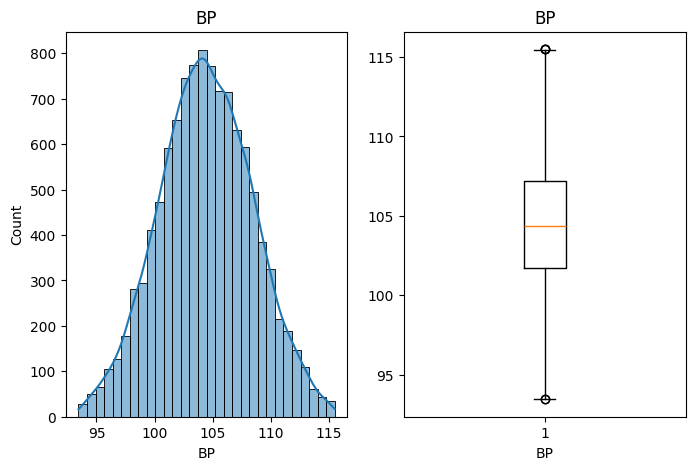

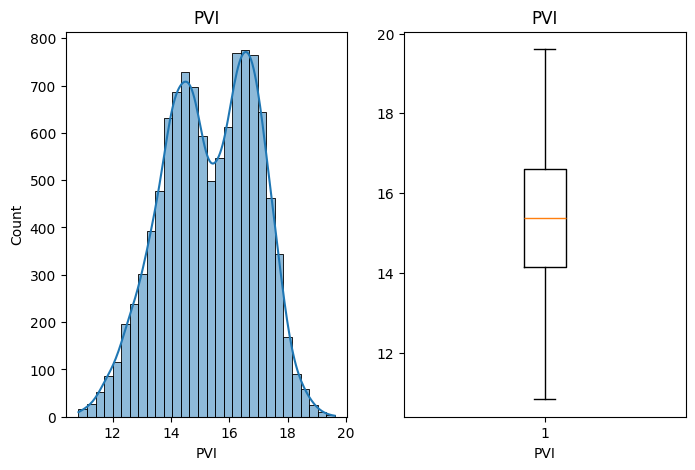

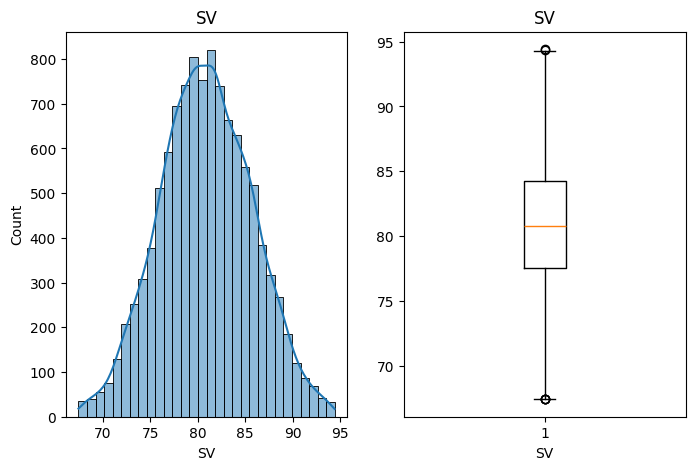

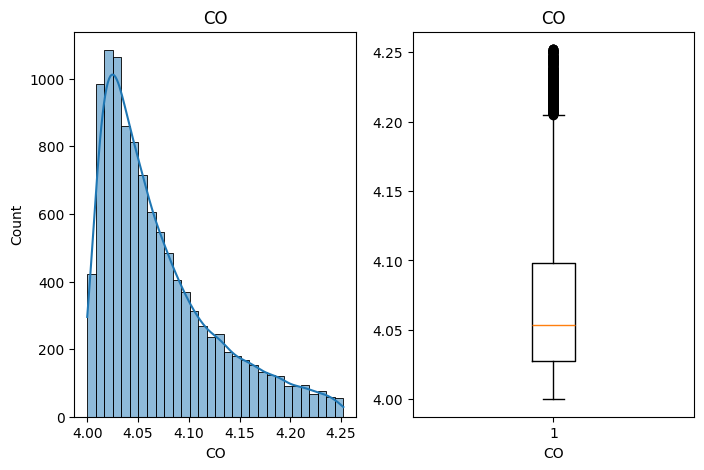

In [43]:
for attribute in cleaned_attributes:
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(observation[attribute], bins=30, kde=True)
    plt.title(f'{attribute}')
    plt.xlabel(f'{attribute}')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(observation[attribute])
    plt.title(f'{attribute}')
    plt.xlabel(f'{attribute}')
    plt.show()

### Replace outliers

In [44]:
def replace_outliers(a):
    lower = a.quantile(0.05)
    upper = a.quantile(0.95)
    
    clipped = a.clip(lower, upper)
    
    return clipped

In [45]:
observation["PRV"] = replace_outliers(observation["PRV"])

observation["Skin Temperature"] = replace_outliers(observation["Skin Temperature"])

observation["SpO₂"] = replace_outliers(observation["SpO₂"])

observation["HR"] = replace_outliers(observation["HR"])

### Visualisation of replaced attributes

In [46]:
replaced_attributes = ["Skin Temperature", "SpO₂", "HR", "PRV"]

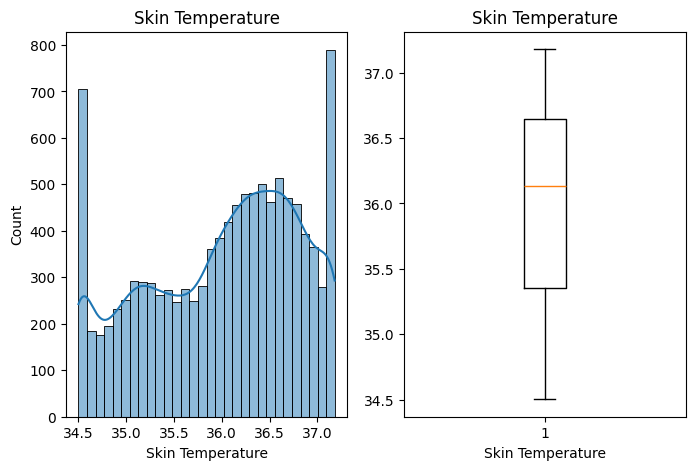

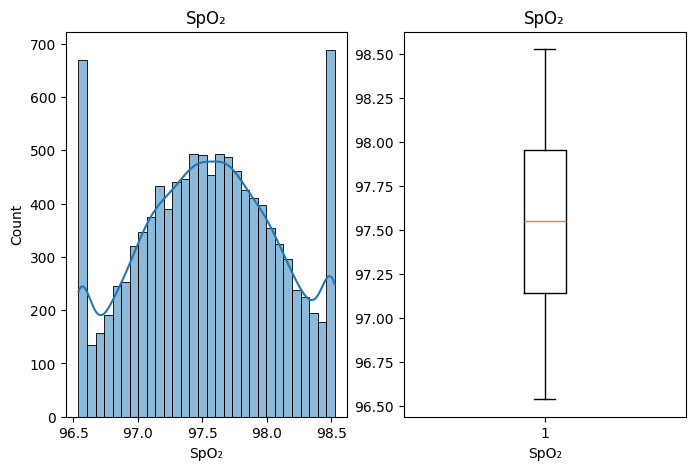

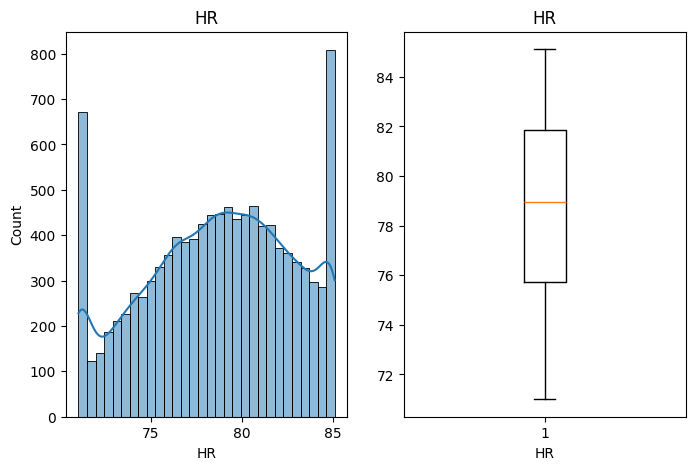

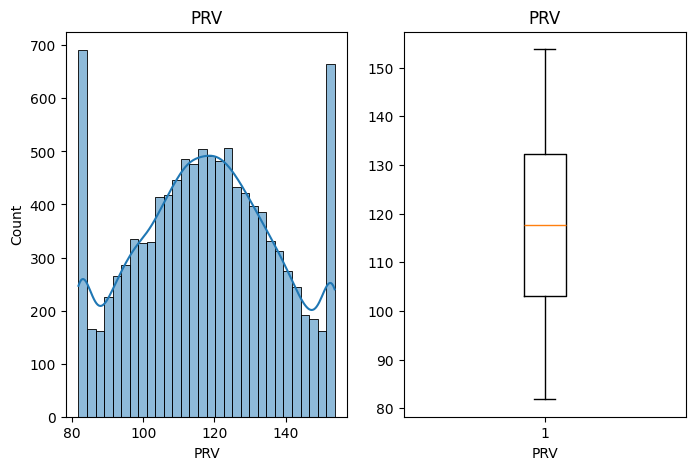

In [47]:
for attribute in replaced_attributes:
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(observation[attribute], bins=30, kde=True)
    plt.title(f'{attribute}')
    plt.xlabel(f'{attribute}')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(observation[attribute])
    plt.title(f'{attribute}')
    plt.xlabel(f'{attribute}')
    plt.show()

# 1.3 A

### Hypotheses


#### H1: The mean SpO₂ is lower under high respiratory effort.

In [48]:
low_effort = observation.loc[observation["Respiratory effort"] <= observation["Respiratory effort"].median(), "SpO₂"]
high_effort = observation.loc[observation["Respiratory effort"] > observation["Respiratory effort"].median(), "SpO₂"]
print("Average SpO₂ during low exertion:", low_effort.mean())
display(low_effort.describe())
print("Average SpO₂ during high exertion:", high_effort.mean())
display(high_effort.describe())

Average SpO₂ during low exertion: 97.53860570301383


count    5505.000000
mean       97.538606
std         0.544775
min        96.539058
25%        97.134240
50%        97.533228
75%        97.948096
max        98.524887
Name: SpO₂, dtype: float64

Average SpO₂ during high exertion: 97.55440069407874


count    5505.000000
mean       97.554401
std         0.548509
min        96.539058
25%        97.154388
50%        97.563162
75%        97.956546
max        98.524887
Name: SpO₂, dtype: float64

In [49]:
sh_low = stats.shapiro(low_effort.sample(5000, random_state=0))
sh_high = stats.shapiro(high_effort.sample(5000, random_state=0))
print("Shapiro p (low):", sh_low.pvalue)
print("Shapiro p (high):", sh_high.pvalue)

Shapiro p (low): 1.4900713760209352e-28
Shapiro p (high): 5.243789320549497e-29


The Shapiro–Wilk test was used to verify the normality of the distribution of SpO₂ values in both groups.
At lower exertion, the test had a p-value of p = 1.49e-28, and at high exertion, p = 5.24е-29, i.e., in both cases (p < 0.05).

A (p-value < 0.05) means that the distribution differs significantly from normal.
Therefore, in addition to the parametric t-test, the non-parametric Mann–Whitney U test, which does not require normal data distribution, was also used in further analysis.

In [50]:
lev = stats.levene(low_effort, high_effort)
print("Levene p:", lev.pvalue)

Levene p: 0.8957234676273715


The Levene test (p = 0.895 > 0.05) confirmed that the variances between the groups are statistically comparable.  
We can therefore use Welch's t-test, which is robust even with small differences in variances.

In [51]:
t, p = stats.ttest_ind(low_effort, high_effort, equal_var=False, nan_policy="omit")
print(f"t = {t:.3f}, p = {p/2:.4f}")

t = -1.516, p = 0.0648


Welch's t-test (t = –1.516, p = 0.0648 > 0.05) did not show a statistically significant difference between the SpO₂ averages during low and high exertion. Thus, a decrease in SpO₂ during increased respiratory load was not confirmed.

In [52]:
u, p_mwu = stats.mannwhitneyu(low_effort, high_effort, alternative="less")
print(f"Mann-Whitney p = {p_mwu:.4f}")

Mann-Whitney p = 0.0456


The Mann–Whitney U test (p = 0.0456 < 0.05) indicated a slight downward trend in SpO₂ during high exertion, but the effect is only borderline statistically significant and very small.
Overall, it can be concluded that increased respiratory effort does not have a significant effect on SpO₂ values in the observed data.

Based on the results of both tests, it can be concluded that although the SpO₂ value is slightly lower during higher respiratory exertion, the difference is not statistically or practically significant.
Hypothesis H₁ (SpO₂ has a lower average value during higher exertion) was not confirmed.

#### H2: RR má v priemere nizsiu hodnotu pri vyššej FiO₂

In [53]:
high_fio2 = observation.loc[observation["FiO₂"] > observation["FiO₂"].median(), "RR"]
low_fio2 = observation.loc[observation["FiO₂"] <= observation["FiO₂"].median(), "RR"]
print("RR average at lower FiO₂:", low_fio2.mean())
display(low_fio2.describe())
print("RR average at higher FiO₂:", high_fio2.mean())
display(high_fio2.describe())

RR average at lower FiO₂: 16.149657547559304


count    5505.000000
mean       16.149658
std         1.034996
min        12.305163
25%        15.462341
50%        16.155756
75%        16.838496
max        19.857284
Name: RR, dtype: float64

RR average at higher FiO₂: 16.117101288746372


count    5505.000000
mean       16.117101
std         1.020380
min        12.000000
25%        15.443488
50%        16.119282
75%        16.809304
max        20.000000
Name: RR, dtype: float64

In [54]:
sh_low = stats.shapiro(low_fio2.sample(5000, random_state=0))
sh_high = stats.shapiro(high_fio2.sample(5000, random_state=0))
print("Shapiro p (low):", sh_low.pvalue)
print("Shapiro p (high):", sh_high.pvalue)

Shapiro p (low): 0.46051975943501716
Shapiro p (high): 0.9837877670569231


Both p-values are > 0.05 ⇒ RR distributions are approximately normal.  
We can therefore use a parametric t-test; to be on the safe side, we will also include a non-parametric test.

In [55]:
lev = stats.levene(low_fio2, high_fio2)
print("Levene p:", lev.pvalue)

Levene p: 0.34807257442822725


p > 0.05 -> there is no evidence of a difference in variance between the groups.  
The variances are comparable; we will use Welch's t-test (robust even for small differences).

In [56]:
u, p_mwu = stats.mannwhitneyu(high_fio2, low_fio2, alternative="less")
print(f"Mann-Whitney p(one-sided)= {p_mwu:.4f}")

Mann-Whitney p(one-sided)= 0.0424


The Mann–Whitney U test (p = 0.042 < 0.05) showed that the RR value is statistically significantly lower at higher FiO₂.
Hypothesis H2 (lower RR at higher FiO₂) was confirmed.

In [57]:
t, p = stats.ttest_ind(high_fio2, low_fio2, equal_var=False, nan_policy="omit")
print(f"t = {t:.3f}, p = {p/2:.4f}")

t = -1.662, p = 0.0483


Both tests (Welch's t-test and Mann–Whitney U) confirm H2: at higher FiO₂, the respiratory rate RR is lower (p < 0.05).  

The data are approximately normally distributed (Shapiro p > 0.05) and have comparable variance (Levene p = 0.33).
Both the one-sided Welch's t-test (t = –1.662, p = 0.0483) and the Mann–Whitney U test (p = 0.042) confirmed that the respiratory rate (RR) is statistically significantly lower at higher FiO₂.

Hypothesis H2 (lower RR at higher FiO₂) was confirmed, but the difference is of little practical significance.
At increased oxygen concentrations, there is a slight but statistically significant decrease in respiratory rate.

## 1.3 B

### Verification of statistical power of the test (H1 – SpO and respiratory effort)

In [58]:
n1 = len(high_effort)
n2 = len(low_effort)
mean1, mean2 = high_effort.mean(), low_effort.mean()
sd1, sd2 = high_effort.std(ddof=1), low_effort.std(ddof=1)


In [59]:
spooled = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2) / (n1+n2-2))
d = (mean1 - mean2) / spooled
print(f"Cohen's d = {d:.4f}")

Cohen's d = 0.0289


The calculated effect size Cohen’s d = 0.0289 represents a very small difference between the groups.  

In [60]:
analysis = TTestIndPower()
power = analysis.power(effect_size=abs(d), nobs1=n1, ratio=n2/n1, alpha = 0.05)
print(f"Statistical power of the test = {power:.3f}")

Statistical power of the test = 0.329


The test has only limited ability to reliably detect such small differences in data.

In [61]:
mde = analysis.solve_power(effect_size=None, nobs1=n1, ratio=n2/n1, alpha=0.05, power=0.8)
print(f"Minimum detectable effect (MDE) = {mde:.3f}")

Minimum detectable effect (MDE) = 0.053


Based on these results, it can be concluded that the difference between respiratory effort levels is not statistically significant and SpO₂ values remain practically stable.  
The test therefore confirms that although there is a statistically small shift, its magnitude is negligible from a physiological point of view.

### Verification of statistical power of the test (H₂ – RR and FiO)

In [62]:
n1 = len(high_fio2)
n2 = len(low_fio2)

mean1, mean2 = high_fio2.mean(), low_fio2.mean()
sd1, sd2 = high_fio2.std(ddof=1), low_fio2.std(ddof=1)

In [63]:
spooled = np.sqrt(((n1 - 1)*sd1**2 + (n2 - 1)*sd2**2) / (n1 + n2 - 2))
d = (mean1 - mean2) / spooled
print(f"Cohen’s d = {d:.4f}")

Cohen’s d = -0.0317


The effect size Cohen’s d = –0.0317 represents a very small and practically negligible difference between the groups.  

In [64]:
analysis = TTestIndPower()
power = analysis.power(effect_size=abs(d), nobs1=n1, ratio=n2/n1, alpha=0.05)
print(f"Statistical power of the test = {power:.3f}")

Statistical power of the test = 0.383


Power = 0.383 is low, meaning that the test has only limited ability to reliably detect such small differences.  

In [65]:
mde = analysis.solve_power(effect_size=None, nobs1=n1, ratio=n2/n1, alpha=0.05, power=0.8)
print(f"Minimum detectable effect (MDE) = {mde:.3f}")

Minimum detectable effect (MDE) = 0.053


Although Welch's t-test and Mann–Whitney test showed a statistically significant difference (p = 0.04), the effect size found is extremely small and therefore has no practical physiological significance.  
Although an increase in oxygen concentration (FiO₂) leads to a slight decrease in respiratory rate (RR), this difference is negligible.

## Conclusion

There were minor issues with the format and quality of the source data.
Some values were of type object, so they were converted to a more suitable type.

In the patient dataset, there were missing values in the columns, which were replaced with the category “Unknown” so as not to lose data when deleting.

One duplicate record was found in the observation table and was deleted.

Rare outliers in the variables were also identified and processed using two methods: IQR deletion and replacement with boundary values (5th and 95th percentiles).

No inconsistent values were found in the data. No violations were found when checking the logical relationships between attributes. All values are mutually consistent and within physiologically acceptable ranges.

After cleaning, the data does not contain duplicates, missing or incorrect values,
making it suitable for further analytical and model processing. 